This file is used for testing and learning how to apply picosdk on Chipwhisperer platform. It includes ChipWhisperer setup code and PicoScope5000 setup and capture code.

The target is tinyaes.

Connect device(ChipWhisperer)

In [1]:
SCOPETYPE = 'OPENADC'
PLATFORM = 'CW308_STM32F4'
CRYPTO_TARGET='TINYAES128C'
SS_VER = 'SS_VER_1_1'

In [2]:
%run "../jupyter/Setup_Scripts/Setup_Generic.ipynb"

INFO: Found ChipWhisperer😍


In [3]:
%%bash -s "$PLATFORM" "$CRYPTO_TARGET" "$SS_VER"

cd ../hardware/victims/firmware/simpleserial-aes
make PLATFORM=$1 CRYPTO_TARGET=$2 SS_VER=$3 -j

Building for platform CW308_STM32F4 with CRYPTO_TARGET=TINYAES128C
SS_VER set to SS_VER_1_1
SS_VER set to SS_VER_1_1
Blank crypto options, building for AES128
Building for platform CW308_STM32F4 with CRYPTO_TARGET=TINYAES128C
SS_VER set to SS_VER_1_1
SS_VER set to SS_VER_1_1
Blank crypto options, building for AES128
make[1]: '.dep' is up to date.
Building for platform CW308_STM32F4 with CRYPTO_TARGET=TINYAES128C
SS_VER set to SS_VER_1_1
SS_VER set to SS_VER_1_1
Blank crypto options, building for AES128
arm-none-eabi-gcc (15:10.3-2021.07-4) 10.3.1 20210621 (release)
Copyright (C) 2020 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

.
Welcome to another exciting ChipWhisperer target build!!
.
Assembling: .././hal/stm32f4/stm32f4_startup.S
arm-none-eabi-gcc -c -mcpu=cortex-m4 -I. -x assembler-with-cpp -mthumb -mfloat-abi=soft -fmessage-length=0 -ffunction-

In file included from .././hal/stm32f4/stm32f4_hal.c:3:
.././hal/stm32f4/stm32f4_hal_lowlevel.h:108: warning: "STM32F415xx" redefined
  108 | #define STM32F415xx
      | 
<command-line>: note: this is the location of the previous definition


.
Compiling:
-en     .././hal/stm32f4/stm32f4_hal.c ...
-e Done!
.
Compiling:
-en     .././crypto/tiny-AES128-C/aes.c ...
-e Done!


In file included from .././hal/stm32f4/stm32f4_hal_lowlevel.c:39:
.././hal/stm32f4/stm32f4_hal_lowlevel.h:108: warning: "STM32F415xx" redefined
  108 | #define STM32F415xx
      | 
<command-line>: note: this is the location of the previous definition


.
Compiling:
-en     .././hal/stm32f4/stm32f4_hal_lowlevel.c ...
-e Done!
.
LINKING:
-en     simpleserial-aes-CW308_STM32F4.elf ...
-e Done!
.
Creating load file for EEPROM: simpleserial-aes-CW308_STM32F4.eep
arm-none-eabi-objcopy -j .eeprom --set-section-flags=.eeprom="alloc,load" \
--change-section-lma .eeprom=0 --no-change-warnings -O ihex simpleserial-aes-CW308_STM32F4.elf simpleserial-aes-CW308_STM32F4.eep || exit 0
.
Creating Symbol Table: simpleserial-aes-CW308_STM32F4.sym
arm-none-eabi-nm -n simpleserial-aes-CW308_STM32F4.elf > simpleserial-aes-CW308_STM32F4.sym
.
Creating load file for Flash: simpleserial-aes-CW308_STM32F4.bin
arm-none-eabi-objcopy -O binary -R .eeprom -R .fuse -R .lock -R .signature simpleserial-aes-CW308_STM32F4.elf simpleserial-aes-CW308_STM32F4.bin
.
Creating load file for Flash: simpleserial-aes-CW308_STM32F4.hex
arm-none-eabi-objcopy -O ihex -R .eeprom -R .fuse -R .lock -R .signature simpleserial-aes-CW308_STM32F4.elf simpleserial-aes-CW308_STM32F4.hex
.

In [4]:
cw.program_target(scope, prog, "../hardware/victims/firmware/simpleserial-aes/simpleserial-aes-{}.hex".format(PLATFORM))

Detected known STMF32: STM32F40xxx/41xxx
Extended erase (0x44), this can take ten seconds or more
Attempting to program 6623 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 6623 bytes


Now we have programmed the target. It is time to configure PicoScope.

In [24]:
import ctypes
import numpy as np
from picosdk.ps5000a import ps5000a as ps
import matplotlib.pyplot as plt
from picosdk.functions import adc2mV,assert_pico_ok,mV2adc

chandle = ctypes.c_int16()
status = {}

resolution = ps.PS5000A_DEVICE_RESOLUTION["PS5000A_DR_12BIT"]
status["openunit"] = ps.ps5000aOpenUnit(ctypes.byref(chandle), None, resolution)

try:
    assert_pico_ok(status["openunit"])
except:
    powerStatus = status["openunit"]
    
    if powerStatus == 286:
        status["changePowerSource"] = ps.ps5000aChangePowerSource(chandle, powerStatus)
    elif powerStatus == 282:
        status["changePowerSource"] = ps.ps5000aChangePowerSource(chnadle, powerStatus)
    else:
        raise
        
    assert_pico_ok(status["changePowerSource"])

In [25]:
# Set up channel A
# handle = chandle

channel = ps.PS5000A_CHANNEL["PS5000A_CHANNEL_A"]
# enabled = 1
coupling_type = ps.PS5000A_COUPLING["PS5000A_DC"]
chARange = ps.PS5000A_RANGE["PS5000A_500MV"]
# analogue offset = 0 V
status["setChA"] = ps.ps5000aSetChannel(chandle, channel, 1, coupling_type, chARange, 0)
assert_pico_ok(status["setChA"])

# Set up channel B
# handle = chandle
channel = ps.PS5000A_CHANNEL["PS5000A_CHANNEL_B"]
# enabled = 1
coupling_type2 = ps.PS5000A_COUPLING["PS5000A_AC"]
chBRange = ps.PS5000A_RANGE["PS5000A_50MV"]
#chBRange = ps.PS5000A_RANGE["PS5000A_200MV"]
# analogue offset = 0 V
status["setChB"] = ps.ps5000aSetChannel(chandle, channel, 1, coupling_type2, chBRange, 0)
assert_pico_ok(status["setChB"])

# find maximum ADC count value
# handle = chandle
# pointer to value = ctypes.byref(maxADC)
maxADC = ctypes.c_int16()
status["maximumValue"] = ps.ps5000aMaximumValue(chandle, ctypes.byref(maxADC))
assert_pico_ok(status["maximumValue"])

# Set up single trigger
# handle = chandle
# enabled = 1
source = ps.PS5000A_CHANNEL["PS5000A_CHANNEL_A"]
threshold = int(mV2adc(40,chARange, maxADC))
# direction = PS5000A_RISING = 2
# delay = 0 s
# auto Trigger = 1000 ms
#status["trigger"] = ps.ps5000aSetSimpleTrigger(chandle, 1, source, threshold, 2, 0, 1000)
status["trigger"] = ps.ps5000aSetSimpleTrigger(chandle, 1, source, threshold, 2, 0, 10000)

assert_pico_ok(status["trigger"])

# Set number of pre and post trigger samples to be collected

preTriggerSamples = 0
postTriggerSamples = 5000
maxSamples = preTriggerSamples + postTriggerSamples

# Get timebase information
# Warning: When using this example it may not be possible to access all Timebases as all channels are enabled by default when opening the scope.  
# To access these Timebases, set any unused analogue channels to off.
# handle = chandle

#timebase = 8
timebase = 4
# noSamples = maxSamples
# pointer to timeIntervalNanoseconds = ctypes.byref(timeIntervalns)
# pointer to maxSamples = ctypes.byref(returnedMaxSamples)
# segment index = 0
timeIntervalns = ctypes.c_float()
returnedMaxSamples = ctypes.c_int32()
status["getTimebase2"] = ps.ps5000aGetTimebase2(chandle, timebase, maxSamples, ctypes.byref(timeIntervalns), ctypes.byref(returnedMaxSamples), 0)
assert_pico_ok(status["getTimebase2"])

Combine ChipWhisperer and PicoSDK code to capture power traces.

In [10]:
from tqdm.notebook import trange
import numpy as np
import time
import chipwhisperer as cw

ktp = cw.ktp.Basic()
key,text = ktp.next()

trace_array = []
trigger_array = []
textin_array = []

target.set_key(key)

N = 50

for i in trange(N, desc='Capture traces'):
    scope.arm()

    target.simpleserial_write('p', text)
    
    
    response = list(target.simpleserial_read('r',16))
    print(response)
    
    #trace_array.append(adc2mVChBMax[:])
    #trigger_array.append(adc2mVChAMax[:])
    textin_array.append(text)
    
    key, text = ktp.next()
    

Capture traces:   0%|          | 0/50 [00:00<?, ?it/s]

[102, 172, 246, 208, 103, 194, 66, 109, 235, 73, 203, 205, 71, 227, 192, 166]
[71, 179, 91, 36, 200, 160, 224, 229, 104, 13, 122, 52, 200, 3, 26, 237]
[176, 144, 162, 122, 245, 182, 127, 60, 219, 176, 52, 255, 189, 129, 170, 232]
[192, 79, 138, 148, 24, 130, 219, 14, 242, 57, 166, 91, 18, 107, 104, 194]
[172, 98, 8, 204, 142, 142, 138, 145, 252, 17, 15, 147, 37, 199, 184, 87]
[66, 39, 232, 7, 254, 121, 250, 147, 224, 34, 98, 93, 139, 233, 170, 29]
[89, 198, 186, 74, 217, 46, 160, 25, 80, 107, 207, 111, 84, 52, 0, 161]
[20, 114, 224, 94, 244, 114, 75, 72, 174, 222, 242, 244, 34, 84, 67, 8]
[223, 174, 46, 229, 90, 23, 36, 65, 30, 236, 101, 14, 34, 58, 133, 125]
[174, 134, 152, 84, 202, 34, 29, 198, 14, 3, 56, 18, 157, 156, 92, 172]
[46, 158, 115, 100, 230, 96, 186, 177, 20, 76, 123, 183, 37, 249, 72, 236]
[9, 20, 12, 26, 1, 200, 58, 232, 63, 57, 173, 204, 162, 210, 242, 242]
[189, 8, 6, 16, 114, 49, 195, 155, 88, 239, 207, 201, 240, 23, 85, 251]
[228, 33, 22, 246, 198, 134, 34, 183, 1, 1

In [ ]:
    status["runBlock"] = ps.ps5000aRunBlock(chandle, preTriggerSamples, postTriggerSamples, timebase, None, 0, None, None)
    assert_pico_ok(status["runBlock"])

    ready = ctypes.c_int16(0)
    check = ctypes.c_int16(0)
    while ready.value == check.value:
        status["isReady"] = ps.ps5000aIsReady(chandle, ctypes.byref(ready))

    bufferAMax = (ctypes.c_int16 * maxSamples)()
    bufferAMin = (ctypes.c_int16 * maxSamples)() # used for downsampling which isn't in the scope of this example
    bufferBMax = (ctypes.c_int16 * maxSamples)()
    bufferBMin = (ctypes.c_int16 * maxSamples)() # used for downsampling which isn't in the scope of this example

    source = ps.PS5000A_CHANNEL["PS5000A_CHANNEL_A"]
    status["setDataBuffersA"] = ps.ps5000aSetDataBuffers(chandle, source, ctypes.byref(bufferAMax), ctypes.byref(bufferAMin), maxSamples, 0, 0)
    assert_pico_ok(status["setDataBuffersA"])
    
    source = ps.PS5000A_CHANNEL["PS5000A_CHANNEL_B"]
    status["setDataBuffersB"] = ps.ps5000aSetDataBuffers(chandle, source, ctypes.byref(bufferBMax), ctypes.byref(bufferBMin), maxSamples, 0, 0)
    assert_pico_ok(status["setDataBuffersB"])

    overflow = ctypes.c_int16()
    cmaxSamples = ctypes.c_int32(maxSamples)

    status["getValues"] = ps.ps5000aGetValues(chandle, 0, ctypes.byref(cmaxSamples), 0, 0, 0, ctypes.byref(overflow))
    assert_pico_ok(status["getValues"])

    adc2mVChAMax =  adc2mV(bufferAMax, chARange, maxADC)
    adc2mVChBMax =  adc2mV(bufferBMax, chBRange, maxADC)
    #plt.plot(adc2mVChAMax[:])	# 画图观察触发信号是否正常
    #plt.plot(adc2mVChBMax[:])	# 画图观察数据信号
    if adc2mVChBMax[0] == 32512 and adc2mVChBMax[-1] == 32512:
            raise Exception('示波器采集错误，请重新采集')

Turn off target and picoscope.

In [28]:
# Stop the scope
# handle = chandle
status["stop"] = ps.ps5000aStop(chandle)
assert_pico_ok(status["stop"])

# Close unit Disconnect the scope
# handle = chandle
status["close"]=ps.ps5000aCloseUnit(chandle)
assert_pico_ok(status["close"])

# display status returns
print(status)

{'openunit': 286, 'changePowerSource': 0, 'setChA': 0, 'setChB': 0, 'maximumValue': 0, 'trigger': 0, 'getTimebase2': 0, 'runBlock': 0, 'isReady': 0, 'setDataBuffersA': 0, 'setDataBuffersB': 0, 'getValues': 0, 'stop': 0, 'close': 0}


Let's see the trace_array.

In [29]:
print(trace_array[0])

[2.5025177770317697, 3.47911008026368, 4.429761650440993, 5.355998413037507, 5.6810205389568775, 5.981627857295449, 5.9312723166600545, 5.781731620227668, 5.180516983550524, 4.429761650440993, 3.8544877468184455, 2.4765770439771724, 1.7517624439222388, 0.39979247413556324, -0.6759849848933378, -1.878414258247627, -3.4302804651020846, -4.356517227698599, -5.456709494308298, -6.30817590868862, -6.909390545365764, -6.933805352946562, -7.460249641407514, -7.1092867824335455, -6.8834498123111665, -6.057924130985443, -5.1576281014435255, -4.080324716940825, -3.0793176061281167, -1.8280587176122318, -0.17548142948698386, 1.4755699331644643, 3.128147221289712, 4.078798791467025, 5.430768761253701, 6.756797997985778, 7.6082644123661, 8.334604937894833, 8.960234382152775, 8.709982604449598, 8.384960478530228, 7.683034760582293, 7.257301553392132, 6.532486953337199, 5.255287331766716, 3.729361857966857, 2.151554918057802, 0.7003997924741355, -1.1017181920834986, -2.6032288583025607, -4.2558061464

In [30]:
assert len(trace_array) == 50

<IPython.core.display.Javascript object>


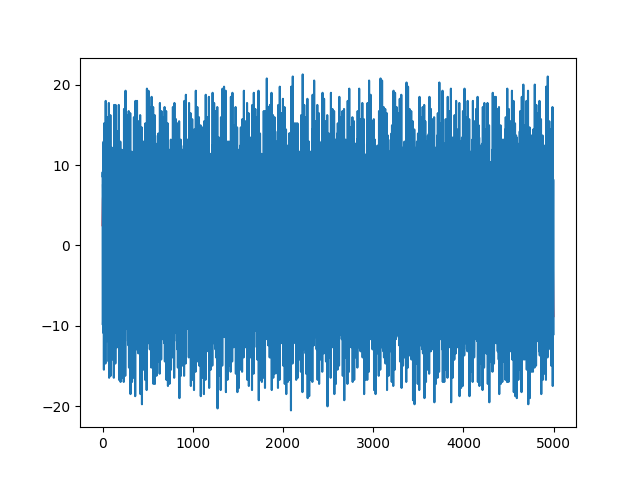

In [31]:
%matplotlib notebook
import matplotlib.pylab as plt

# ###################
# Add your code here
# ###################
# raise NotImplementedError("Add your code here, and delete this.")

# cw.plot(trace_array[0]) * cw.plot(trace_array[1])
plt.plot(trace_array[0],'r')
#plt.plot(trace_array[1],'g')
plt.plot(trigger_array[0])

In [32]:
sbox = [
    # 0    1    2    3    4    5    6    7    8    9    a    b    c    d    e    f 
    0x63,0x7c,0x77,0x7b,0xf2,0x6b,0x6f,0xc5,0x30,0x01,0x67,0x2b,0xfe,0xd7,0xab,0x76, # 0
    0xca,0x82,0xc9,0x7d,0xfa,0x59,0x47,0xf0,0xad,0xd4,0xa2,0xaf,0x9c,0xa4,0x72,0xc0, # 1
    0xb7,0xfd,0x93,0x26,0x36,0x3f,0xf7,0xcc,0x34,0xa5,0xe5,0xf1,0x71,0xd8,0x31,0x15, # 2
    0x04,0xc7,0x23,0xc3,0x18,0x96,0x05,0x9a,0x07,0x12,0x80,0xe2,0xeb,0x27,0xb2,0x75, # 3
    0x09,0x83,0x2c,0x1a,0x1b,0x6e,0x5a,0xa0,0x52,0x3b,0xd6,0xb3,0x29,0xe3,0x2f,0x84, # 4
    0x53,0xd1,0x00,0xed,0x20,0xfc,0xb1,0x5b,0x6a,0xcb,0xbe,0x39,0x4a,0x4c,0x58,0xcf, # 5
    0xd0,0xef,0xaa,0xfb,0x43,0x4d,0x33,0x85,0x45,0xf9,0x02,0x7f,0x50,0x3c,0x9f,0xa8, # 6
    0x51,0xa3,0x40,0x8f,0x92,0x9d,0x38,0xf5,0xbc,0xb6,0xda,0x21,0x10,0xff,0xf3,0xd2, # 7
    0xcd,0x0c,0x13,0xec,0x5f,0x97,0x44,0x17,0xc4,0xa7,0x7e,0x3d,0x64,0x5d,0x19,0x73, # 8
    0x60,0x81,0x4f,0xdc,0x22,0x2a,0x90,0x88,0x46,0xee,0xb8,0x14,0xde,0x5e,0x0b,0xdb, # 9
    0xe0,0x32,0x3a,0x0a,0x49,0x06,0x24,0x5c,0xc2,0xd3,0xac,0x62,0x91,0x95,0xe4,0x79, # a
    0xe7,0xc8,0x37,0x6d,0x8d,0xd5,0x4e,0xa9,0x6c,0x56,0xf4,0xea,0x65,0x7a,0xae,0x08, # b
    0xba,0x78,0x25,0x2e,0x1c,0xa6,0xb4,0xc6,0xe8,0xdd,0x74,0x1f,0x4b,0xbd,0x8b,0x8a, # c
    0x70,0x3e,0xb5,0x66,0x48,0x03,0xf6,0x0e,0x61,0x35,0x57,0xb9,0x86,0xc1,0x1d,0x9e, # d
    0xe1,0xf8,0x98,0x11,0x69,0xd9,0x8e,0x94,0x9b,0x1e,0x87,0xe9,0xce,0x55,0x28,0xdf, # e
    0x8c,0xa1,0x89,0x0d,0xbf,0xe6,0x42,0x68,0x41,0x99,0x2d,0x0f,0xb0,0x54,0xbb,0x16  # f
]

def aes_internal(inputdata, key):
    return sbox[inputdata ^ key]

HW = [bin(n).count("1") for n in range(0, 256)]

In [33]:
assert HW[aes_internal(0xA1, 0x79)] == 3
assert HW[aes_internal(0x22, 0xB1)] == 5
print("✔️ OK to continue!")

✔️ OK to continue!


In [34]:
def mean(X):
    return np.sum(X, axis=0)/len(X)

def std_dev(X, X_bar):
    return np.sqrt(np.sum((X-X_bar)**2, axis=0))

def cov(X, X_bar, Y, Y_bar):
    return np.sum((X-X_bar)*(Y-Y_bar), axis=0)

In [35]:
a = np.array([[5, 3, 4, 4, 5, 6],
             [27, 2, 3, 4, 12, 6],
              [1, 3, 5, 4, 5, 6],
              [1, 2, 3, 4, 5, 6],
             ]).transpose()
a_bar = mean(a)
b = np.array([[5, 4, 3, 2, 1, 3]]).transpose()
b_bar = mean(b)

o_a = std_dev(a, a_bar)
o_b = std_dev(b, b_bar)

ab_cov = cov(a, a_bar, b, b_bar)

In [36]:
assert (a_bar == np.array([4.5, 9., 4., 3.5])).all()
assert (b_bar == np.array([3.])).all()
assert (o_a[3] > 4.1833001 and o_a[3] < 4.1833002)
assert (o_b[0] > 3.162277 and o_b[0] < 3.162278)
assert (ab_cov == np.array([-1., 28., -9., -10.])).all()
print("✔️ OK to continue!")

✔️ OK to continue!


In [37]:
from tqdm.notebook import trange
maxcpa = [0] * 256

# we don't need to redo the mean and std dev calculations 
# for each key guess
t_bar = mean(trace_array) 
o_t = std_dev(trace_array, t_bar)

for kguess in trange(0, 256):
    hws = np.array([[HW[aes_internal(textin[0],kguess)] for textin in textin_array]]).transpose()
    
    hws_bar = mean(hws)
    o_hws = std_dev(hws, hws_bar)
    correlation = cov(trace_array, t_bar, hws, hws_bar)
    cpaoutput = correlation/(o_t*o_hws)
    maxcpa[kguess] = max(abs(cpaoutput))
    

guess = np.argmax(maxcpa)
guess_corr = max(maxcpa)

print("Key guess: ", hex(guess))
print("Correlation: ", guess_corr)

  0%|          | 0/256 [00:00<?, ?it/s]

Key guess:  0x2b
Correlation:  0.7680440382359892


In [38]:
print(key)

CWbytearray(b'2b 7e 15 16 28 ae d2 a6 ab f7 15 88 09 cf 4f 3c')


In [39]:
t_bar = np.sum(trace_array, axis=0)/len(trace_array)
o_t = np.sqrt(np.sum((trace_array - t_bar)**2, axis=0))

cparefs = [0] * 16 #put your key byte guess correlations here
bestguess = [0] * 16 #put your key byte guesses here

for bnum in trange(0, 16):
    maxcpa = [0] * 256
    for kguess in range(0, 256):
    # ###################
    # Add your code here
    # ###################
    #raise NotImplementedError("Add your code here, and delete this.")
    
    # ###################
    # START SOLUTION
    # ###################
        hws = np.array([[HW[aes_internal(textin[bnum],kguess)] for textin in textin_array]]).transpose()
        hws_bar = mean(hws)
        o_hws = std_dev(hws, hws_bar)
        correlation = cov(trace_array, t_bar, hws, hws_bar)
        cpaoutput = correlation/(o_t*o_hws)
        maxcpa[kguess] = max(abs(cpaoutput))
    bestguess[bnum] = np.argmax(maxcpa)
    cparefs[bnum] = max(maxcpa)
    # ###################
    # END SOLUTION
    # ###################

print("Best Key Guess: ", end="")
for b in bestguess: print("%02x " % b, end="")
print("\n", cparefs)

  0%|          | 0/16 [00:00<?, ?it/s]

Best Key Guess: 2b 7e 15 16 28 ae d2 a6 ab f7 15 88 09 cf 4f 3c 
 [0.7680440382359892, 0.6725409229592467, 0.61023163432436, 0.7195146460220353, 0.6833024677408199, 0.6804542926112404, 0.6596308583246583, 0.7214262975048602, 0.696090582893603, 0.6448598501576674, 0.6085874082304974, 0.6223401010665275, 0.7001166118306523, 0.6726066538048887, 0.6422408942516384, 0.7578417125182699]


In [40]:
for bnum in range(16):
    assert bestguess[bnum] == key[bnum], \
    "Byte {} failed, expected {:02X} got {:02X}".format(bnum, key[bnum], bestguess[bnum])
print("✔️ OK to continue!")

✔️ OK to continue!
